In [81]:
# encoding: utf-8
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt

filename = 'movebase_time.csv'
filename_husky = 'husky_poses.csv'
point_file = 'waypoint.csv'
outfile = 'date_result.csv'
outfile_mean = 'mean_out.csv'


In [82]:
def get_data_from_movebase_time():
    df = pd.read_csv(filename)
    husky = pd.read_csv(filename_husky)
    
    df = df[df.status == 3].reset_index(drop = True)   #消除状态标志不是3的数据

    #数据的筛选，取时间戳前后0.1秒的数据进行求和平均
    data = []
    for i in range(len(df.time)):
        pose_temp = husky[(husky.timestamp > (df.time[i] - 0.1)) & (husky.timestamp < (df.time[i] + 0.1))]
        entry = pose_temp.mean().values
        columns_index = pose_temp.mean().index
        data.append(entry)

    df_1 = pd.DataFrame(data, columns = columns_index)
    
        #对获取的数据进行筛选，去到达目标点的第一个时刻的数据
    temp_x = df_1.x[0]
    temp_y = df_1.y[0]
    pose = []
    pose.append([df_1.timestamp[0], df_1.x[0], df_1.y[0], df_1.z[0], df_1.yaw[0], df_1.roll[0], df_1.pitch[0]])
    for i in range(len(df_1.x) - 1):
        if ((df_1.x[i] - temp_x)**2 + (df_1.y[i] - temp_y)**2)**0.5 < 1:
            continue
        else:
            temp_x = df_1.x[i]
            temp_y = df_1.y[i]
            pose.append([df_1.timestamp[i], df_1.x[i], df_1.y[i], df_1.z[i], df_1.yaw[i], df_1.roll[i], df_1.pitch[i]])
    pose
    
    list_1 = ['timestamp', 'x','y','z','yaw','roll','pitch']
    
    df_1 = pd.DataFrame(pose, columns = list_1)  #获取数据
    
    return df_1

In [83]:
def get_erro_to_csv(df, pointfile):
    
    point = pd.read_csv(pointfile)
    
    df_1 = df
    df_2 = df_1.drop(['timestamp'], axis = 1)  #消除时间戳的信息，与waypoint.csv文件格式一致，用于对比

    times = len(df_2)//len(point)
    re = len(df_2)%len(point)

    point_sum = point
    for i in range(times - 1):
        point_sum = point_sum.append(point).reset_index().drop(['index'], axis = 1)
    point_sum = point_sum.append(point[0:re]).reset_index().drop(['index'], axis = 1)

    erro = df_2 - point_sum
    erro['timestamp'] = df_1.timestamp
    
    list_1 = ['timestamp', 'x','y','z','yaw','roll','pitch']

    erro = erro.reindex(columns=list_1)
    # print(erro)
    test = df_1.diff(1)

    ## 获取机器人运动轨迹的距离

    husky_dis = husky[(husky.timestamp > erro.timestamp[0]) & (husky.timestamp < erro.timestamp[len(erro)-1])]
    # husky_dis = husky_dis[husky_dis.timestamp < erro.timestamp[len(erro)-1]]
    husky_dis = husky_dis.reset_index().drop('index', axis = 1)

    list_1 = ['timestamp', 'x', 'y']
    husky_dis = husky_dis.reindex(columns=list_1)

    husky_sqr = husky_dis.diff(1).reset_index().drop(['index','timestamp'], axis = 1)

    husky_sqr['sqr'] = (husky_sqr.x**2 + husky_sqr.y**2)**0.5
    husky_sqr['timestamp'] = husky_dis.timestamp

    real_dis = []
    for i in range(len(erro)-1):
        temp_sqr = husky_sqr[(husky_sqr.timestamp > erro.timestamp[i]) & (husky_sqr.timestamp < erro.timestamp[i+1])]
        real_dis.append(temp_sqr.sqr.sum())
    real_dis.insert(0,np.nan)

    ##

    erro['time'] = test.timestamp
    erro['dist'] = real_dis
    erro['vel'] = erro['dist'] / erro['time']
    erro.to_csv(outfile, index = False)
    
    return erro
    
#     print(erro.head())


In [84]:
def get_mean_data():
    ## 获取均值

    index_ls = ['p1-2','p2-3','p3-4','p4-5','p5-6','p6-7','p7-8','p8-9','p9-1']

    #获取每个点在loop中的平均值
    df_1 = erro
    data_test = []
    n_points = 9
    for i in range(0, len(df_1), 9):
        df_temp_1 = df_1.time[i:i+9]
    #     print(df_temp_1)
        df_temp_2 = df_1.dist[i:i+9]
    #     print(df_temp_2)
        df_temp_3 = df_1.vel[i:i+9]
        entry = list(df_temp_1) + list(df_temp_2) + list(df_temp_3)
        data_test.append(entry)

    columns_name = ['time_loop_'+str(i+1) for i in range(n_points)]+['dis_loop_'+str(i+1) for i in range(n_points)]+['vel_loop_'+str(i+1) for i in range(n_points)]

    df_out = pd.DataFrame(data_test, columns = columns_name)

    list_mean = list(df_out.mean())
    list_mean  
    #获取5个loop的距离信息\

    loop_mean_time = list_mean[0:9]
    loop_mean_dist = list_mean[9:18]
    loop_mean_vel = list_mean[18:]

    mean_list = [loop_mean_time, loop_mean_dist, loop_mean_vel]
    mean_out = pd.DataFrame(mean_list, columns = index_ls)
    mean_out['mean'] = ['time_mean', 'dist_mean', 'vel_mean']

    index_list_out = ['mean','p1-2','p2-3','p3-4','p4-5','p5-6','p6-7','p7-8','p8-9','p9-1']
    mean_out.reindex(columns = index_list_out)
    mean_out.to_csv(outfile_mean, index = False)

    plt.plot(index_ls, loop_mean_time, '*')
    plt.xlabel('waypoints')
    plt.ylabel('mean_time / s')
    plt.title('mean_time for 5 loops')
    plt.savefig('./mean_time.png', dpi = 900, bbox_inches = 'tight')
    plt.show()

    plt.plot(index_ls, loop_mean_dist, '*')
    plt.xlabel('waypoints')
    plt.ylabel('mean_dist / m')
    plt.title('mean_time for 5 loops')
    plt.savefig('./mean_dist.png', dpi = 900, bbox_inches = 'tight')
    plt.show()

    plt.plot(index_ls, loop_mean_vel, '*')
    plt.xlabel('waypoints')
    plt.ylabel('loop_mean_vel m/s')
    plt.title('mean_vel for 5 loops')
    plt.savefig('./mean_vel.png', dpi = 900, bbox_inches = 'tight')
    plt.show()

    ##

In [85]:
def get_picture_loop():

    #获取9个位置点之间的实际距离（两点间的直线距离）
    real_dis = point.append(point[0:1]).reset_index().drop(['index'], axis = 1)
    real_dis = real_dis.diff(1).shift(-1)[0:9]
    real_dis['dis'] = (real_dis.x**2 + real_dis.y**2)**0.5

    #获取机器人运动过程总的时间，距离，速度
    list_temp = ['timestamp', 'time', 'dist', 'vel']
    data_robot = erro.reindex(columns=list_temp)
    data_robot = data_robot.shift(-1)[:len(data_robot)-1]

    data = {'point':[1,2,3,4,5,6,7,8,9]}  #创建新的dataframe
    df_robot = pd.DataFrame(data)

    #获取5个loop的时间信息
    df_robot['time_loop_1'] = data_robot.time[0:9].reset_index(drop = True)
    df_robot['time_loop_2'] = data_robot.time[9:18].reset_index(drop = True)
    df_robot['time_loop_3'] = data_robot.time[18:27].reset_index(drop = True)
    df_robot['time_loop_4'] = data_robot.time[27:36].reset_index(drop = True)
    df_robot['time_loop_5'] = data_robot.time[36:].reset_index(drop = True)

    #获取5个loop的距离信息
    df_robot['dist_loop_1'] = data_robot.dist[0:9].reset_index(drop = True)
    df_robot['dist_loop_2'] = data_robot.dist[9:18].reset_index(drop = True)
    df_robot['dist_loop_3'] = data_robot.dist[18:27].reset_index(drop = True)
    df_robot['dist_loop_4'] = data_robot.dist[27:36].reset_index(drop = True)
    df_robot['dist_loop_5'] = data_robot.dist[36:].reset_index(drop = True)

    #获取5个loop的速度信息
    df_robot['vel_loop_1'] = data_robot.vel[0:9].reset_index(drop = True)
    df_robot['vel_loop_2'] = data_robot.vel[9:18].reset_index(drop = True)
    df_robot['vel_loop_3'] = data_robot.vel[18:27].reset_index(drop = True)
    df_robot['vel_loop_4'] = data_robot.vel[27:36].reset_index(drop = True)
    df_robot['vel_loop_5'] = data_robot.vel[36:].reset_index(drop = True)




    #画散点图，time
    # plt.subplot(2,1,1)
    plt.plot(index_ls, df_robot.time_loop_1, '.')
    plt.plot(index_ls, df_robot.time_loop_2, '*')
    plt.plot(index_ls, df_robot.time_loop_3, '<')
    plt.plot(index_ls, df_robot.time_loop_4, '^')
    plt.plot(index_ls, df_robot.time_loop_5, '>')

    plt.xlabel('waypoints')
    plt.ylabel('time/s')
    plt.legend(loc = 'best')
    plt.title('waypoints time for 5 loops')
    plt.savefig('./time.png', dpi = 900, bbox_inches = 'tight')

    plt.show()

    #画散点图，dist
    # plt.subplot(2,1,1)
    plt.plot(index_ls, df_robot.dist_loop_1, '.')
    plt.plot(index_ls, df_robot.dist_loop_2, '*')
    plt.plot(index_ls, df_robot.dist_loop_3, '<')
    plt.plot(index_ls, df_robot.dist_loop_4, '^')
    plt.plot(index_ls, df_robot.dist_loop_5, '>')

    #机器人的真实直线距离
    plt.plot(index_ls, real_dis.dis, '*r')

    plt.xlabel('waypoints')
    plt.ylabel('distance/m')
    plt.legend(loc = 'best')
    plt.title('waypoints distance for 5 loops')
    plt.savefig('./distance.png', dpi = 900, bbox_inches = 'tight')

    plt.show()

    #画散点图，dist
    # plt.subplot(2,1,1)

    df_robot.dist_loop_1 = df_robot.dist_loop_1/real_dis.dis
    df_robot.dist_loop_2 = df_robot.dist_loop_2/real_dis.dis
    df_robot.dist_loop_3 = df_robot.dist_loop_3/real_dis.dis
    df_robot.dist_loop_4 = df_robot.dist_loop_4/real_dis.dis
    df_robot.dist_loop_5 = df_robot.dist_loop_5/real_dis.dis

    plt.plot(index_ls, df_robot.dist_loop_1, '.')
    plt.plot(index_ls, df_robot.dist_loop_2, '*')
    plt.plot(index_ls, df_robot.dist_loop_3, '<')
    plt.plot(index_ls, df_robot.dist_loop_4, '^')
    plt.plot(index_ls, df_robot.dist_loop_5, '>')

    #机器人的真实直线距离
    # plt.plot(df_robot.point, real_dis.dis, '*r')

    plt.xlabel('waypoints')
    plt.ylabel('dist / dis')
    plt.legend(loc = 'best')
    plt.title('waypoints distance/dis for 5 loops')
    plt.savefig('./distance_dis.png', dpi = 900, bbox_inches = 'tight')

    plt.show()

    #画散点图，velocity
    # plt.subplot(2,1,1)
    plt.plot(index_ls, df_robot.vel_loop_1, '.')
    plt.plot(index_ls, df_robot.vel_loop_2, '*')
    plt.plot(index_ls, df_robot.vel_loop_3, '<')
    plt.plot(index_ls, df_robot.vel_loop_4, '^')
    plt.plot(index_ls, df_robot.vel_loop_5, '>')

    plt.xlabel('waypoints')
    plt.ylabel('velocity/ m/s')
    plt.legend(loc = 'best')
    plt.title('waypoints velocity for 5 loops')
    plt.savefig('./velocity.png', dpi = 900, bbox_inches = 'tight')

    plt.show()

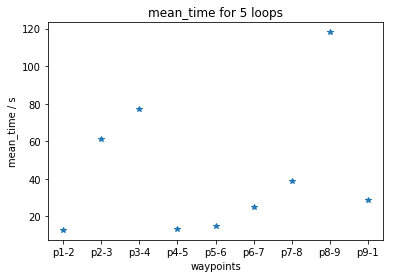

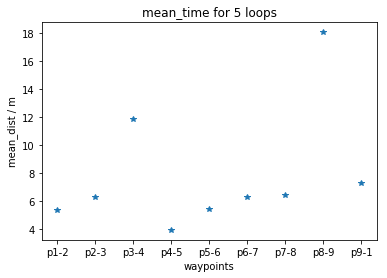

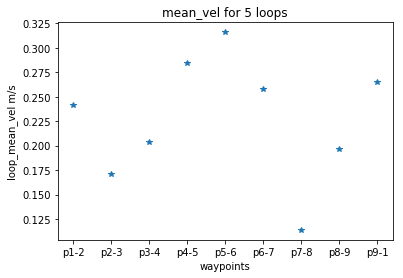

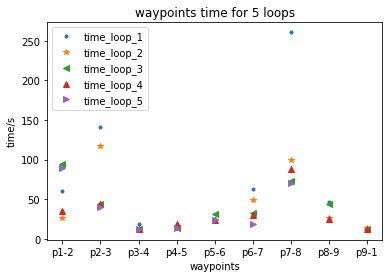

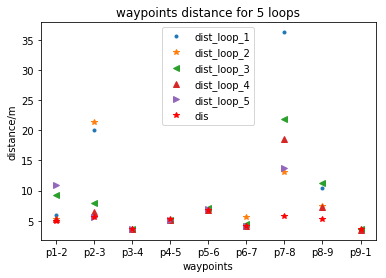

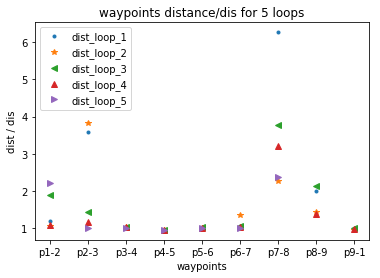

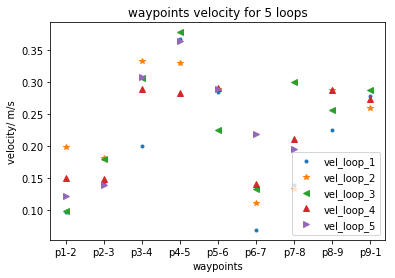

In [86]:
if __name__ == '__main__':
    df_1 = get_data_from_movebase_time()
    erro = get_erro_to_csv(df_1, point_file)
    get_mean_data()
    get_picture_loop()